In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [2]:
# Importing the tables of monthly features.
m1 = pd.read_excel("mth_rolling_features.xlsx")
m2 = pd.read_excel("mth_day_counts.xlsx")
m3 = pd.read_excel("days_since_last_txn.xlsx")

In [3]:
# Importing the response table.
resp = pd.read_csv("Retail_Data_Response.csv")

In [4]:
# Merging the monthly features.
monthly_feat = pd.merge(pd.merge(m1, m2, on=["CLNT_NO", "ME_DT"]), m3, on=["CLNT_NO", "ME_DT"])
# Renaming the 'customer_id' column in the response table to 'CLNT_NO' for joining.
resp.rename(columns={"customer_id": "CLNT_NO"}, inplace=True)
# Joining the monthly features with the response.
monthly_data = pd.merge(monthly_feat, resp, on="CLNT_NO")

monthly_data

,Unnamed: 0_x,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,...,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,Unnamed: 0,days_since_last_txn,response
0,157064,CS1112,2011-05-31,0,0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,157064,-100,0
1,157058,CS1112,2011-06-30,56,1,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,157058,15,0
2,157044,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,...,0,0,0,0,0,0,0,157044,46,0
3,157069,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,...,1,0,0,0,0,0,0,157069,12,0
4,157060,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,...,0,0,0,0,0,0,0,157060,42,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,295140,CS9000,2014-11-30,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,295140,98,0
323544,295126,CS9000,2014-12-31,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,295126,129,0
323545,295119,CS9000,2015-01-31,0,0,0.0,0.000000,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,295119,160,0
323546,295136,CS9000,2015-02-28,34,1,34.0,11.333333,34.0,1.0,0.333333,...,0,0,1,0,0,0,0,295136,0,0


In [5]:
# Dropping the unnecessary NaN rows from window size and the "Unnamed" index columns.
monthly_data.dropna(inplace=True)
monthly_data.drop(columns=["Unnamed: 0", "Unnamed: 0_x", "Unnamed: 0_y"], inplace=True)
monthly_data

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
11,CS1112,2012-04-30,56,1,56.0,18.666667,56.0,1.0,0.333333,1.0,...,1.0,0,0,0,1,0,0,0,22,0
12,CS1112,2012-05-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,1.0,0,0,0,0,0,0,0,53,0
13,CS1112,2012-06-30,52,1,108.0,36.000000,56.0,2.0,0.666667,1.0,...,1.0,0,0,0,1,0,0,0,6,0
14,CS1112,2012-07-31,81,1,133.0,44.333333,81.0,2.0,0.666667,1.0,...,1.0,0,0,0,0,0,1,0,28,0
15,CS1112,2012-08-31,0,0,133.0,44.333333,81.0,2.0,0.666667,1.0,...,1.0,0,0,0,0,0,0,0,59,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,2014-11-30,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,98,0
323544,CS9000,2014-12-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,129,0
323545,CS9000,2015-01-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,1.0,0,0,0,0,0,0,0,160,0
323546,CS9000,2015-02-28,34,1,34.0,11.333333,34.0,1.0,0.333333,1.0,...,1.0,0,0,1,0,0,0,0,0,0


In [6]:
# Obtaining the client IDs.
clients = monthly_data['CLNT_NO'].unique()
# Shuffling unique client IDs
np.random.seed(15)
np.random.shuffle(clients)
# Splitting the data into two halves based on Client IDs
train_clients, holdout_clients = np.array_split(clients, 2)
sample_data, holdout_data = monthly_data[monthly_data['CLNT_NO'].isin(train_clients)], monthly_data[monthly_data['CLNT_NO'].isin(holdout_clients)]

print(f"Sample data: {sample_data.shape}, Holdout data: {holdout_data.shape}")

Sample data: (123912, 31), Holdout data: (123912, 31)


In [7]:
# Splitting the sample data into training (up to Dec-2013) and production (test) (Jan-2014 and beyond).
train, test = sample_data[sample_data["ME_DT"] <= "2013-12-31"], sample_data[sample_data["ME_DT"] >= "2014-01-01"]
X_train, y_train = train.drop(columns=["CLNT_NO", "ME_DT", "response"]), train["response"]

print(f"Train data: {train.shape}, Test data: {test.shape}")

Train data: (72282, 31), Test data: (51630, 31)


In [8]:
# Best Random_forest
model = RandomForestClassifier(max_depth=5, class_weight="balanced", random_state=1147)
# Fitting the model.
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=1147)

In [9]:
# Obtaining the baseline feature importances.
base_importance = model.feature_importances_

# Selecting the indexes of the top 5 features based on baseline importance.
top_5_features = np.argsort(base_importance)[-5:][::-1]
top_5_features = [X_train.columns[i] for i in top_5_features]
top_5_features

['amt_max_12M', 'amt_sum_12M', 'amt_mean_12M', 'amt_max_6M', 'amt_mean_6M']

In [10]:
# Identifying the best bin edges using a DecisionTreeRegressor for each feature.
bin_edges = {}
for feature in top_5_features:
    dt = DecisionTreeRegressor(max_depth=3)
    dt.fit(X_train[[feature]], y_train)
    # Limiting to max 10 bins for better visibility of distribution.
    num_bins = min(10, len(np.unique(X_train[feature])))
    bin_edges[feature] = np.linspace(X_train[feature].min(), X_train[feature].max(), num=num_bins)
    counts, _ = np.histogram(X_train[feature], bins=bin_edges[feature])
    print(f"{feature} bin counts:", counts)

amt_max_12M bin counts: [ 4054 23310 23153 14354  5217  1716   427    29    22]
amt_sum_12M bin counts: [14498 22139 19153 11015  4123  1090   229    28     7]
amt_mean_12M bin counts: [14498 22139 19153 11015  4123  1090   229    28     7]
amt_max_6M bin counts: [13926 27908 18074  8494  2745   871   235    15    14]
amt_mean_6M bin counts: [26428 22124 13884  6536  2356   744   148    50    12]


In [11]:
# Viewing the best bin edges for each feature.
for feature, edges in bin_edges.items():
    print(f"{feature}: {edges}")

amt_max_12M: [  0.  46.  92. 138. 184. 230. 276. 322. 368. 414.]
amt_sum_12M: [   0.          146.33333333  292.66666667  439.          585.33333333
  731.66666667  878.         1024.33333333 1170.66666667 1317.        ]
amt_mean_12M: [  0.          12.19444444  24.38888889  36.58333333  48.77777778
  60.97222222  73.16666667  85.36111111  97.55555556 109.75      ]
amt_max_6M: [  0.  46.  92. 138. 184. 230. 276. 322. 368. 414.]
amt_mean_6M: [  0.          15.92592593  31.85185185  47.77777778  63.7037037
  79.62962963  95.55555556 111.48148148 127.40740741 143.33333333]


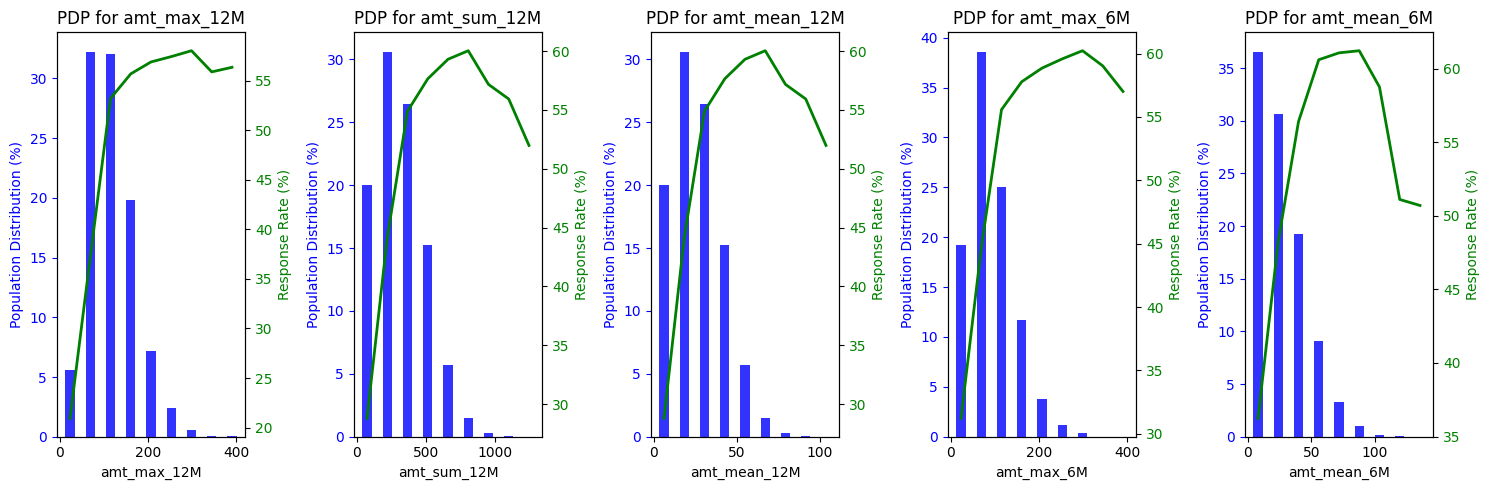

In [12]:
# Visualizing the Partial dependency plots for the top 5 features.
fig, axes = plt.subplots(1, len(top_5_features), figsize=(15, 5))

for i, feature in enumerate(top_5_features):
    # Creating lists to hold binned values and predictions.
    binned_values = []
    population_distribution = []
    response_rate = []
    # Retrieving bin edges for the feature.
    bins = bin_edges[feature]

    # Looping through the bins and calculating the mean prediction for each bin.
    for j in range(1, len(bins)):
        # Selecting rows within the bin range.
        in_bin = (X_train[feature] >= bins[j-1]) & (X_train[feature] < bins[j])
        bin_data = X_train[in_bin]
        # Predicting probabilities for the bin.
        bin_predictions = model.predict_proba(bin_data)[:, 1]
        # Storing the midpoint of the bin for the X-axis.
        binned_values.append((bins[j-1] + bins[j]) / 2)
        # Storing the population distribution.
        population_distribution.append(len(bin_data) / len(X_train) * 100)
        # Storing the average predicted response for the bin.
        response_rate.append(bin_predictions.mean() * 100)

    # Adjusting bar width dynamically based on bin range.
    bar_width = (max(bins) - min(bins)) / (2 * len(bins))
    axes[i].bar(binned_values, population_distribution, width=bar_width, color='blue', alpha=0.8)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Population Distribution (%)", color='blue')
    axes[i].set_title(f"PDP for {feature}")
    axes[i].tick_params(axis='y', colors='blue')
    # Creating secondary y-axis for response rate.
    ax2 = axes[i].twinx()
    ax2.set_ylabel("Response Rate (%)", color='green')
    ax2.plot(binned_values, response_rate, label="Response Rate", color='green', lw=2)
    ax2.tick_params(axis='y', labelcolor='green')
    axes[i].grid(False)

plt.tight_layout()
plt.show()

#### Answer (Interpretation of PDPs for Top 5 features):
- From observation of the PDPs, the response rate increases sharply for all 5 features across the smaller values of the range then generally peaks after the median values of their ranges. Clients with amt_max_12M greater 100 have a higher probability to respond positively to the campaign. amt_sum_12M and amt_mean_12M have the same population distribution (one is a version of the other) and ultimately the same impact on the response rate such that client's with values between 600 to 900 and 60 to 90 respectively have a much higher chance to accept the offer. Clients with amt_max_6M greater 100 have a higher probability to accept the offer as well. The partial dependence observed for amt_mean_6M is a bit more different than the others; values between 50 and 80 have are most likely to lead to an accepted offer and an increase in values beyond this range causes a sharp drop in the response rate. While a drop towards the largest values is also experienced by other features, this drop is much steeper signifying a more a favoured region for positve responses.
- The observed effect may not generalise well for higher values because the majority of data points are focused in the lower range for all features. Since there were few data points with high values for all features, the PD estimations are less reliable in some areas.    

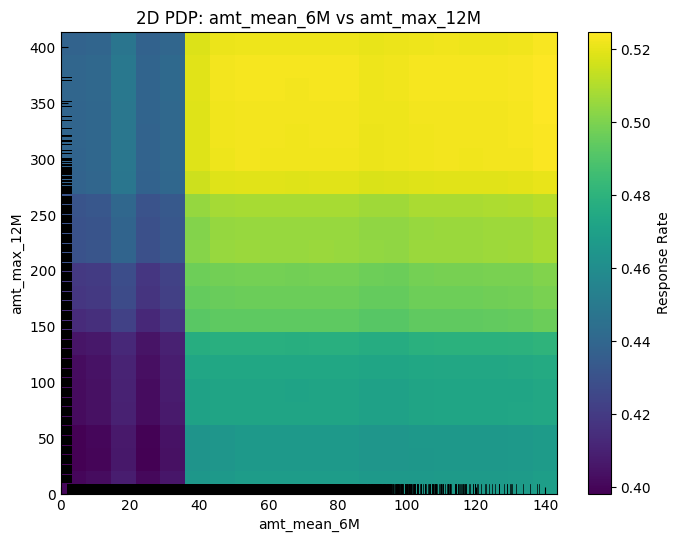

In [13]:
# Defining the feature pair for 2D PDP.
feature_1, feature_2 = "amt_mean_6M", "amt_max_12M"
features = [feature_1, feature_2]

# Computing the Partial Dependence and extracting grid valaues(for both features) and PDP values.
pdp_results = partial_dependence(model, X_train, features, grid_resolution=20)
values_x = pdp_results["grid_values"][0]
values_y = pdp_results["grid_values"][1]
response_values = pdp_results["average"][0]
# Fetching the feature ranges from X_train to scale the heatmap correctly.
x_min, x_max = X_train[feature_1].min(), X_train[feature_1].max()
y_min, y_max = X_train[feature_2].min(), X_train[feature_2].max()

# Creating the heatmap.
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(response_values, aspect="auto", origin="lower", extent=[x_min, x_max, y_min, y_max],cmap="viridis")
cbar = plt.colorbar(heatmap, ax=ax)
cbar.set_label("Response Rate")
ax.set_xlabel(feature_1)
ax.set_ylabel(feature_2)
ax.set_title(f"2D PDP: {feature_1} vs {feature_2}")

# Adding in rug plots along the axes to show values.
ax.tick_params(axis='x', direction='in', length=5, color='black')
ax.tick_params(axis='y', direction='in', length=5, color='black')
# Calibrating Rug plot on X-axis.
for value in X_train[feature_1]:
    ax.axvline(x=value, ymin=0, ymax=0.02, color='black', lw=0.5)
# Calibrating Rug plot on Y-axis.
for value in X_train[feature_2]:
    ax.axhline(y=value, xmin=0, xmax=0.02, color='black', lw=0.5)

plt.show()

#### Answer (Interpretation of 2D PDP):
- The 2D PDP shows the interaction of "amt_mean_6M" and "amt_max_12M" and the pairs'impact on the respose rate. The interaction appears to have a higher value for the lowest response rate. The plot shows the increase in the probabilty of positive response to the campaign offer at a "amt_mean_6M" value of 35. Combining that value with a value of "amt_max_12M" greater than 275 leads to the interaction's highest probability of a client accepting the promotion offer.